In [36]:
import yaml
from yaml import Loader
import pandas as pd

In [37]:
# data dictionary
MODEL = "model"
METHOD = "method"
HAS_TOP_HIT = "has_top_hit"
IN_TOP_5 = "in_top_5"
IN_TOP_10 = "in_top_10"
RANK = "rank"
SIZE_OVERLAP = "size_overlap"
SIMILARITY = "similarity"
GENESET = "geneset"
SOURCE_GENESET = "source_geneset"
GENESET_SIZE = "geneset_size"
TRUNCATION_FACTOR = "truncation_factor"
NUM_TERMS = "num_terms"


TURBO = "gpt-3.5-turbo"
DAVINCI = "text-davinci-003"
MODELS = [TURBO, DAVINCI]

In [38]:
from ontogpt.evaluation.enrichment.eval_enrichment import GeneSetComparison, Overlap

In [39]:
def load_comparisons():
    with open(f"../analysis/enrichment-summary.yaml") as f:
        obj = yaml.load(f, Loader)
        comps = [GeneSetComparison(**x) for x in obj]
        return comps

In [40]:
comps = load_comparisons()

In [41]:
comps[0].name

'EDS-0'

In [42]:
list(comps[0].__dict__.keys())

['name',
 'gene_symbols',
 'model',
 'payloads',
 'overlaps',
 'number_of_genes_swapped_out']

In [43]:
payload = comps[0].payloads["gpt-3.5-turbo.no_synopsis"]
list(payload.__dict__.keys())

['prompt',
 'response_text',
 'truncation_factor',
 'summary',
 'term_strings',
 'term_ids',
 'ontological_synopsis',
 'combined_synopsis',
 'annotations',
 'response_token_length',
 'model',
 'method']

In [44]:
def eval_payload(comp, method, payload, expected):
    name = comp.name
    model = payload.model
    # temp...
    if not model:
        toks = method.split(".")
        for m in MODELS:
            if method.startswith(m):
                model = m
                method = method.replace(f"{m}.", "")
                break
    if not model:
        model = "N/A"
    tf = payload.truncation_factor
    if not tf:
        tf = 1.0
    obj = {MODEL: model, METHOD: method, GENESET: name, TRUNCATION_FACTOR: tf}
    name_toks = name.split("-")
    obj[SOURCE_GENESET] = "-".join(name_toks[0:-1])
    if not expected.term_ids:
        #print(f"Nothing expected for {name}")
        # top_term_id = "FAKE:123"
        return
    else:
        top_term_id = expected.term_ids[0]
    obj[HAS_TOP_HIT] = top_term_id in payload.term_ids
    in_top_5 = False
    in_top_10 = False
    if top_term_id in payload.term_ids:
        rank = payload.term_ids.index(top_term_id)
        obj[RANK] = rank
        in_top_5 = rank < 5
        in_top_10 = rank < 10
    obj[IN_TOP_5] = in_top_5
    obj[IN_TOP_10] = in_top_10
    overlap = set(payload.term_ids).intersection(expected.term_ids)
    obj[SIZE_OVERLAP] = len(overlap)
    size_union = len(set(payload.term_ids).union(expected.term_ids))
    if size_union:
        obj['similarity'] = len(overlap) / len(set(payload.term_ids).union(expected.term_ids))
    obj['number_of_terms'] = len(payload.term_ids)
    obj[GENESET_SIZE] = len(comp.gene_symbols)
    obj['term_ids'] = payload.term_ids
    obj['term_strings'] = payload.term_strings
    obj[NUM_TERMS] = len(payload.term_ids)
    return obj

objs = []
for comp in comps:
    expected = comp.payloads["standard"]
    for method, payload in comp.payloads.items():
        obj = eval_payload(comp, method, payload, expected)
        if obj:
            objs.append(obj)
df = pd.DataFrame(objs)
df.to_csv("enr.csv")
df

In [ ]:
df[[SOURCE_GENESET]].drop_duplicates()

,source_geneset
0,EDS
40,FA
80,HALLMARK_APICAL_JUNCTION
120,HALLMARK_GLYCOLYSIS
160,HALLMARK_HEDGEHOG_SIGNALING
200,HALLMARK_INTERFERON_GAMMA_RESPONSE
240,HALLMARK_MTORC1_SIGNALING
280,Yamanaka-TFs
320,amigo-example
360,term-GO:0007212


In [ ]:
eval_summary_cols = [MODEL, METHOD, HAS_TOP_HIT, IN_TOP_5, IN_TOP_10, SIZE_OVERLAP, SIMILARITY, NUM_TERMS]
means = df[eval_summary_cols].groupby([MODEL, METHOD]).mean(numeric_only=True)
means

has_top_hit  in_top_5  in_top_10  \
model            method                                                   
N/A              random                   0.044118  0.014706   0.014706   
                 rank_based               0.058824  0.000000   0.000000   
                 standard                 1.000000  1.000000   1.000000   
                 standard_no_ontology     0.058824  0.058824   0.058824   
gpt-3.5-turbo    narrative_synopsis       0.191176  0.176471   0.191176   
                 no_synopsis              0.250000  0.250000   0.250000   
                 ontological_synopsis     0.279412  0.279412   0.279412   
text-davinci-003 narrative_synopsis       0.161765  0.102941   0.161765   
                 no_synopsis              0.117647  0.088235   0.117647   
                 ontological_synopsis     0.220588  0.147059   0.205882   

                                       size_overlap  similarity   num_terms  
model            method                                                      
N/A              random                    5.058824    0.013096   65.485294  
                 rank_based                9.470588    0.024061   74.882353  
                 standard                180.455882    1.000000  180.455882  
                 standard_no_ontology      8.264706    0.034783   10.970588  
gpt-3.5-turbo    narrative_synopsis        2.220588    0.024211    5.500000  
                 no_synopsis               2.573529    0.020299    6.073529  
                 ontological_synopsis      2.279412    0.026870    5.647059  
text-davinci-003 narrative_synopsis        1.632353    0.009590    9.529412  
                 no_synopsis               1.720588    0.010134    8.661765  
                 ontological_synopsis      1.970588    0.016442   11.088235

In [47]:
means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold')

### Effect of truncation

Larger gene sets penalize annotation-based GPT methods due to the necessity to truncate to fit in the window size.



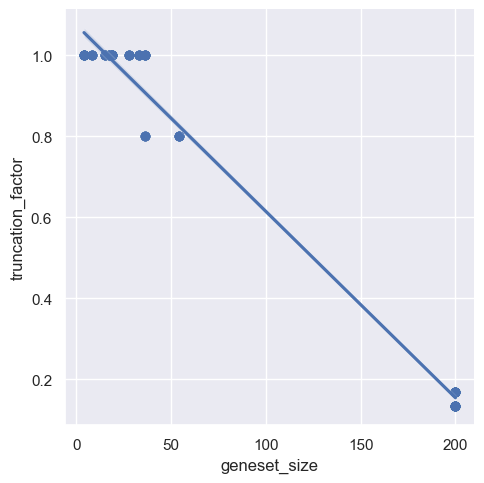

In [48]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.lmplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=df.query("method=='ontological_synopsis'"))
plt.show()

<Axes: xlabel='geneset_size', ylabel='truncation_factor'>

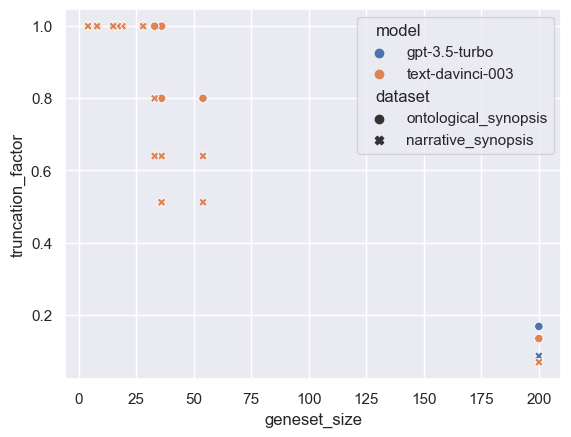

In [49]:
dftups = [(method, df.query(f"method=='{method}'")) for method in ["ontological_synopsis", "narrative_synopsis"]]
for m, mdf in dftups:
    mdf.assign(dataset=m)
concatenated = pd.concat([mdf.assign(dataset=m) for m, mdf in dftups])
sns.scatterplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=concatenated, style='dataset', hue='model')

In [50]:
    df.query(f"{GENESET_SIZE} < 75")[[SOURCE_GENESET]].drop_duplicates()

,source_geneset
0,EDS
40,FA
160,HALLMARK_HEDGEHOG_SIGNALING
280,Yamanaka-TFs
320,amigo-example
360,term-GO:0007212
400,go-postsynapse-calcium-transmembrane
440,go-reg-autophagy-pkra
480,meiosis I
560,peroxisome


In [51]:
means = df.query(f"{GENESET_SIZE} < 75")[eval_summary_cols].groupby(['model', 'method']).mean(numeric_only=True)
means

has_top_hit  in_top_5  in_top_10  \
model            method                                                   
N/A              random                   0.020833  0.020833   0.020833   
                 rank_based               0.000000  0.000000   0.000000   
                 standard                 1.000000  1.000000   1.000000   
                 standard_no_ontology     0.083333  0.083333   0.083333   
gpt-3.5-turbo    narrative_synopsis       0.187500  0.187500   0.187500   
                 no_synopsis              0.229167  0.229167   0.229167   
                 ontological_synopsis     0.312500  0.312500   0.312500   
text-davinci-003 narrative_synopsis       0.125000  0.083333   0.125000   
                 no_synopsis              0.083333  0.062500   0.083333   
                 ontological_synopsis     0.291667  0.187500   0.270833   

                                       size_overlap  similarity   num_terms  
model            method                                                      
N/A              random                    0.979167    0.005339   21.875000  
                 rank_based                1.750000    0.010549   22.750000  
                 standard                127.937500    1.000000  127.937500  
                 standard_no_ontology      6.708333    0.030042    9.187500  
gpt-3.5-turbo    narrative_synopsis        1.812500    0.029633    5.270833  
                 no_synopsis               2.104167    0.024195    5.500000  
                 ontological_synopsis      2.145833    0.034462    5.145833  
text-davinci-003 narrative_synopsis        1.520833    0.010969    8.750000  
                 no_synopsis               1.437500    0.011109    7.687500  
                 ontological_synopsis      2.291667    0.021872   10.145833

In [52]:
from oaklib import get_adapter
go = get_adapter("sqlite:obo:go")
def terms_summary(df):
    term_dict = {}
    for _, row in df.iterrows():
        mm = f"{row['model']}.{row['method']}"
        for ix, t_id in enumerate(row["term_ids"]):
            if t_id not in term_dict:
                t = {"id": t_id, "label": go.label(t_id)}
                term_dict[t_id] = t
            else:
                t = term_dict[t_id]
            t[mm] = ix
    objs = list(term_dict.values())
    return pd.DataFrame(objs)

In [53]:
means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold')

### Peroxisome

In [54]:
peroxisome = df.query(f"{GENESET} == 'peroxisome-0'").sort_values("similarity", ascending=False)
peroxisome[eval_summary_cols]

,model,method,has_top_hit,in_top_5,in_top_10,size_overlap,similarity,num_terms
586,N/A,standard,True,True,True,62,1.000000,62
566,N/A,standard,True,True,True,62,1.000000,62
581,gpt-3.5-turbo,ontological_synopsis,False,False,False,3,0.048387,3
580,gpt-3.5-turbo,no_synopsis,False,False,False,3,0.045455,8
562,gpt-3.5-turbo,narrative_synopsis,False,False,False,2,0.031250,9
582,gpt-3.5-turbo,narrative_synopsis,False,False,False,2,0.031250,4
561,gpt-3.5-turbo,ontological_synopsis,False,False,False,2,0.030769,5
560,gpt-3.5-turbo,no_synopsis,False,False,False,1,0.015625,3
563,text-davinci-003,no_synopsis,False,False,False,1,0.015385,5
564,text-davinci-003,ontological_synopsis,False,False,False,1,0.014706,8


In [55]:
terms_summary(peroxisome)

,id,label,N/A.standard,gpt-3.5-turbo.no_synopsis,text-davinci-003.no_synopsis,gpt-3.5-turbo.ontological_synopsis,gpt-3.5-turbo.narrative_synopsis,text-davinci-003.ontological_synopsis,text-davinci-003.narrative_synopsis,N/A.rank_based,N/A.random
0,GO:0006625,protein targeting to peroxisome,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GO:0072663,establishment of protein localization to peroxisome,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GO:0072662,protein localization to peroxisome,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GO:0015919,peroxisomal membrane transport,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0043574,peroxisomal transport,4.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0007031,peroxisome organization,5.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN
6,GO:0016558,protein import into peroxisome matrix,6.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
7,GO:0005778,peroxisomal membrane,7.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
8,GO:0031903,microbody membrane,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GO:0016562,"protein import into peroxisome matrix, receptor recycling",9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sensory Ataxia

In [56]:
ataxia = df.query(f"{GENESET} == 'sensory ataxia-0'").sort_values("similarity", ascending=False)
ataxia[eval_summary_cols]                                                           

,model,method,has_top_hit,in_top_5,in_top_10,size_overlap,similarity,num_terms
666,N/A,standard,True,True,True,9,1.000000,9
646,N/A,standard,True,True,True,9,1.000000,9
662,gpt-3.5-turbo,narrative_synopsis,True,True,True,2,0.200000,3
642,gpt-3.5-turbo,narrative_synopsis,False,False,False,2,0.200000,3
661,gpt-3.5-turbo,ontological_synopsis,True,True,True,2,0.200000,3
641,gpt-3.5-turbo,ontological_synopsis,True,True,True,2,0.181818,4
640,gpt-3.5-turbo,no_synopsis,True,True,True,2,0.133333,8
668,N/A,random,False,False,False,0,0.000000,14
667,N/A,standard_no_ontology,False,False,False,0,0.000000,0
665,text-davinci-003,narrative_synopsis,False,False,False,0,0.000000,8


In [57]:
terms_summary(ataxia)

,id,label,N/A.standard,gpt-3.5-turbo.narrative_synopsis,gpt-3.5-turbo.ontological_synopsis,gpt-3.5-turbo.no_synopsis,text-davinci-003.ontological_synopsis,N/A.rank_based,N/A.random,text-davinci-003.narrative_synopsis,text-davinci-003.no_synopsis
0,GO:0042552,myelination,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1,GO:0008366,axon ensheathment,1.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2,GO:0007272,ensheathment of neurons,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GO:0007422,peripheral nervous system development,3.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,GO:0014037,Schwann cell differentiation,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GO:0010001,glial cell differentiation,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GO:0032287,peripheral nervous system myelin maintenance,6.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,GO:0006264,mitochondrial DNA replication,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GO:0042063,gliogenesis,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GO:0031175,neuron projection development,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Summaries

In [58]:
objs = []
for c in comps:
    for m, payload in c.payloads.items():
        if payload.summary:
            objs.append({"model": c.model, "geneset": c.name, "method": m, "summary": payload.summary})

In [59]:
sdf = pd.DataFrame(objs)

In [60]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
sdf

In [61]:
sdf.query("geneset == 'sensory ataxia-0'")

,model,geneset,method,summary
408,None,sensory ataxia-0,gpt-3.5-turbo.no_synopsis,"Summary: Enriched terms are related to myelin sheath formation, neuronal development, and protein processing.\n"
409,None,sensory ataxia-0,gpt-3.5-turbo.ontological_synopsis,"Summary: These genes are involved in various processes related to the peripheral nervous system and nucleic acid metabolism, including myelination, DNA replication, and protein ubiquitination.\nMechanism: These genes may be involved in the maintenance, repair, and regulation of the peripheral nervous system and nucleic acids.\n"
410,None,sensory ataxia-0,gpt-3.5-turbo.narrative_synopsis,"Summary: Genes are involved in various neurological and metabolic disorders. Enriched terms include ""peripheral nervous system development,"" ""neurological system process,"" and ""mitochondrial DNA replication.""\n\nMechanism: The enriched terms suggest a common theme of neurological and metabolic dysfunction related to the peripheral nervous system and mitochondrial function.\n\n"
411,None,sensory ataxia-0,text-davinci-003.no_synopsis,Summary: The given genes are enriched for proteins in cytoskeleton organization and signaling; glycoprotein metabolism and signaling; and ion channel activity and signaling. \n
412,None,sensory ataxia-0,text-davinci-003.ontological_synopsis,"Summary: Enriched terms were found for proteins involved in cellular processes such as membrane transport, apoptotic regulation, transcription regulation, intracellular protein transport, DNA/RNA processing, mitochondrial transport, and sensory perception. \n\nMechanism: These proteins likely act as components of the intracellular transport machinery and are involved in multiple processes such as protein folding, DNA/RNA processing, and protein ubiquitination. They may also form complexes to regulate the transcription machinery and regulate cell apoptosis.\n\n"
413,None,sensory ataxia-0,text-davinci-003.narrative_synopsis,"\nSummary: Genes involved in Charcot-Marie-Tooth diseases, neurological disorders, and other hematological conditions have been identified. \nMechanism: Genes related to peripheral nerve myelin upkeep, mitochondrial DNA polymerase, E3 ubiquitin ligase, DNA helicase, GPI-Moonlighting proteins, Nuclear pore complex and transcription factor are involved in maintaining neuronal activity, replication of mitochondrial DNA, protein ubiquitination, unwinding of double-stranded DNA, glycolysis and transcription of proteins, which are all essential for proper nerve conduction and maintenance of health cells. \n"
420,None,sensory ataxia-0,gpt-3.5-turbo.no_synopsis,Summary: The common function of the genes appears to be related to neurological processes and protein metabolism. \n\n
421,None,sensory ataxia-0,gpt-3.5-turbo.ontological_synopsis,Summary: Genes are commonly involved in peripheral nervous system myelination and neuromuscular diseases.\nMechanism: These genes are involved in the proper development and maintenance of the peripheral nervous system.\n
422,None,sensory ataxia-0,gpt-3.5-turbo.narrative_synopsis,"Summary: Genes are primarily involved in peripheral nervous system function and diseases, specifically Charcot-Marie-Tooth disease and related neuropathies. \nMechanism: Possibly related to myelin maintenance and/or nerve impulse transmission in the peripheral nervous system. \n"
423,None,sensory ataxia-0,text-davinci-003.no_synopsis,"\nSummary: The list of genes provided are involved in wide range of functions such as regulation of cell signaling pathways, chromatin remodeling, structure and organization of nervous system, lipid metabolic processes, cation transport and intra-cellular transport of proteins.\n\n"
